In [1]:
!pip install textblob

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd
import nltk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from tqdm import tqdm
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fritt/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<br><br>
## Part 1: Creating the sentiment dataframe
First we are extracting the apple data from the already filtered csv-files. These were created using the Extraction_of_relevant_apple_data.ipynb jupyter notebook.

In [ ]:
df = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df = df.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

In [ ]:
df.head()

Changing the dataframe columns to their appropriate data types.

In [ ]:
df.quoteID = df.quoteID.astype('string')
df.quotation = df.quotation.astype('string')
df.speaker = df.speaker.astype('string')
df.numOccurrences = df.numOccurrences.astype('int32')

In [ ]:
df.dtypes

Sorting the dataframe by date so we get the correct order of the dataframes for the sentiment graph that will be created later

In [ ]:
df = df.sort_values('date')
df.head()

For each row in the dataframe we will attach 4 new columns, neg, neu, pos and compound. These values are the negative, neutral, positive and compound values we get from the SentimentIntensityAnalyzer polary scores.

In [ ]:
column_names = ['quoteID', 'quotation', 'speaker', 'date', 'numOccurrences','neg', 'neu', 'pos', 'compound']
    
sentiment_info_df = pd.DataFrame(columns = column_names)

print("Total number of rows: ", df.shape[0])
for idx, row in tqdm(df.iterrows()):
    
    # Calculating scores from SentimentIntensityAnalyzer
    new_row_dct = SentimentIntensityAnalyzer().polarity_scores(row['quotation'])
    
    # Creating and writing over value    
    new_row_dct['quoteID'] = row['quoteID']
    new_row_dct['quotation'] = row['quotation']
    new_row_dct['speaker'] = row['speaker']
    new_row_dct['date'] = row['date']
    new_row_dct['numOccurrences'] = row['numOccurrences']
    new_row = pd.DataFrame(new_row_dct, columns=column_names, index=[0])
    sentiment_info_df = sentiment_info_df.append(new_row)


We will also attach a date_clean column to the dataframe which only contains the date and not the timestamp.

In [ ]:
# Sorting by datetime
sentiment_info_df_sorted = sentiment_info_df.set_index('quoteID').sort_values('date')

# Clean the date column, such that it only contains date information and not timestamp
sentiment_info_df_sorted['date_clean'] = sentiment_info_df_sorted.apply(lambda x: x['date'][:10],axis=1)
sentiment_info_df_sorted.head()

We will save the current dataframe to csv since the analysis part takes around 20 minutes, so we don't have to redo that part each time we are going to change something in the notebook.

In [ ]:
#sentiment_info_df_sorted.to_csv('./data/sentiment_df.csv')

<br><br>
## Part 2: Sentiment analysis
Here we firstly read the dataframe from the csv and remove the fortnite outlier quote, which contains 39 978 occurences. This quote was decided to be removed in the exploratory part of the project.

In [3]:
# Read from csv to recreate a the fresh dataframe
sentiment_df = pd.read_csv('./data/sentiment_df.csv')
#finding index of outlier
print(sentiment_df[sentiment_df.numOccurrences == 39978])
#removing outlier
sentiment_df = sentiment_df.drop(58674)

Empty DataFrame
Columns: [Unnamed: 0, quoteID, quotation, speaker, date, numOccurrences, neg, neu, pos, compound, date_clean]
Index: []


**Raw datapoints visualized:**  
Firstly we will visualize the datapoints for positive and negative tweets, these tweets will need a treshold of at least +/- 0.6 to ensure that we don't register all the neutral tweets.  
- Green points: positive tweets
- Red points: negative tweets

This visualization is mainly to get a feeling of how to points are distributed, but it won't give us a lot of information straight away. It is just too much information for a human being to interpret, we will therefore make an aggregated graph based on the positive and negative points.  


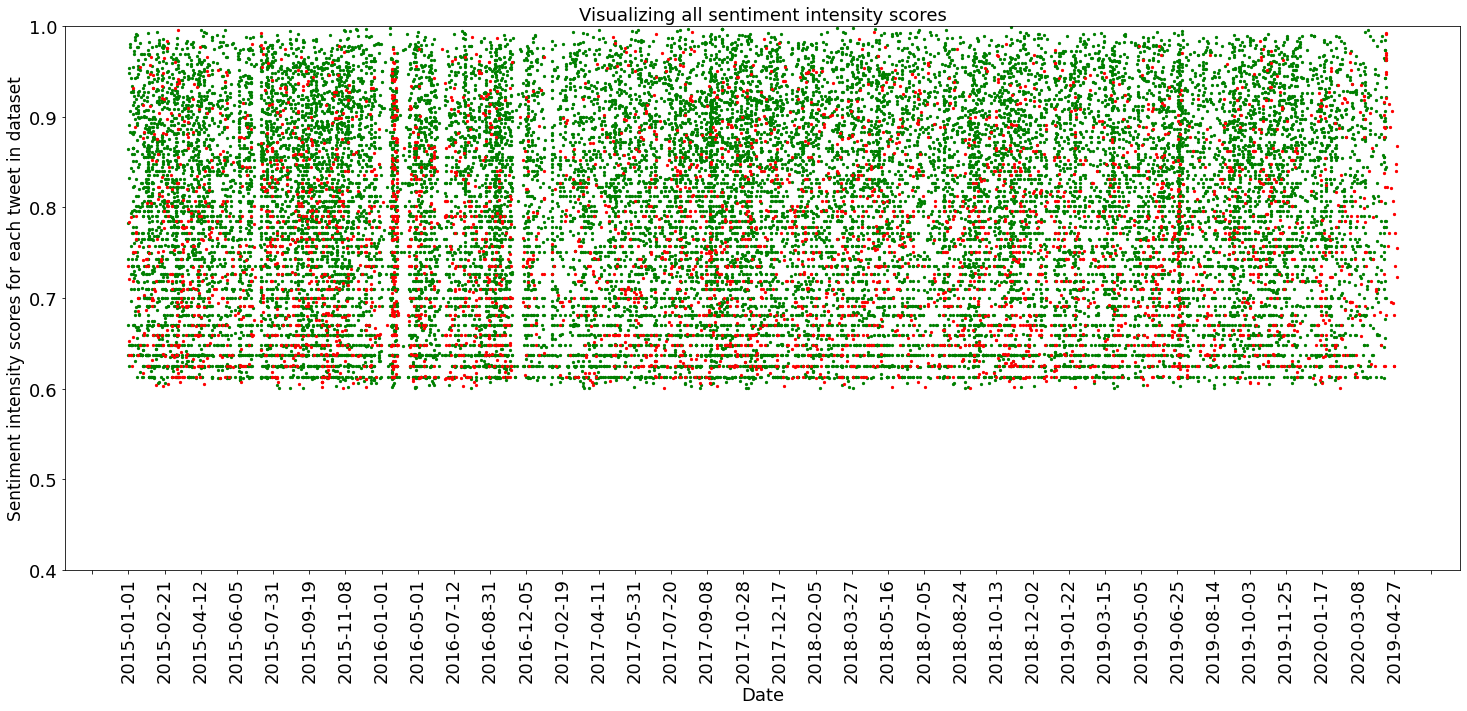

In [4]:
fig,ax = plt.subplots(figsize=(25,10))

cutoff_decimal = 0.6


pos_scores_df = sentiment_df[sentiment_df['compound'] > cutoff_decimal]
pos_scores = pos_scores_df['compound']
pos_dates = pos_scores_df['date_clean']

neg_scores_df = sentiment_df[sentiment_df['compound'] < -cutoff_decimal]
neg_scores = -neg_scores_df['compound']
neg_dates = neg_scores_df['date_clean']
ax.set_ylim([0.4,1])
ax.scatter(pos_dates, pos_scores, s=5, color='green')
ax.scatter(neg_dates, neg_scores, s=5, color='red')

loc = plticker.MultipleLocator(base=50) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.title('Visualizing all sentiment intensity scores', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sentiment intensity scores for each tweet in dataset', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(rotation=90)
plt.show()

## 1 month aggregated sentiment intensity scores

Positive tweets will account for their value (given from SentimentIntensityAnalyzer) times +1 and times numOccurences.  
Negative tweets will account for their value (given from SentimentIntensityAnalyzer) times -1 and times numOccurences. 

In [5]:
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_month = date[:7]
        current_size = 0


    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)
    
    # updates weighted aggregated value of positive and negative
    current_size += row['compound']*row['numOccurrences']

    
    

**For the datastory:**
For our sentiment analysis, we have labeled every quote in our apple dataset with a sentiment compound score between -1.0 and 1.0. Since there are too many quotes to represent visually, we have aggregated quote scores for each month and visualized the aggregated score for that month. These calculations heavily depend on the sentiment tool, so to secure that we don't include neutral quotes or quotes that the tool is hesitant about, we have made an arbitrarily cutoff of 0.6. Therefore, the graph will not include sentiment intensity scores between -0.6 and 0.6 in the calculations.

Comments on the graph: As we can see by the chart there seems to be a disproportionate balance between positive and negative quotes since most months, the aggregated score is far above 0. We can also see a reduction in sentiment intensity scores from late 2019 until early 2020 - which may be caused by covid-19.

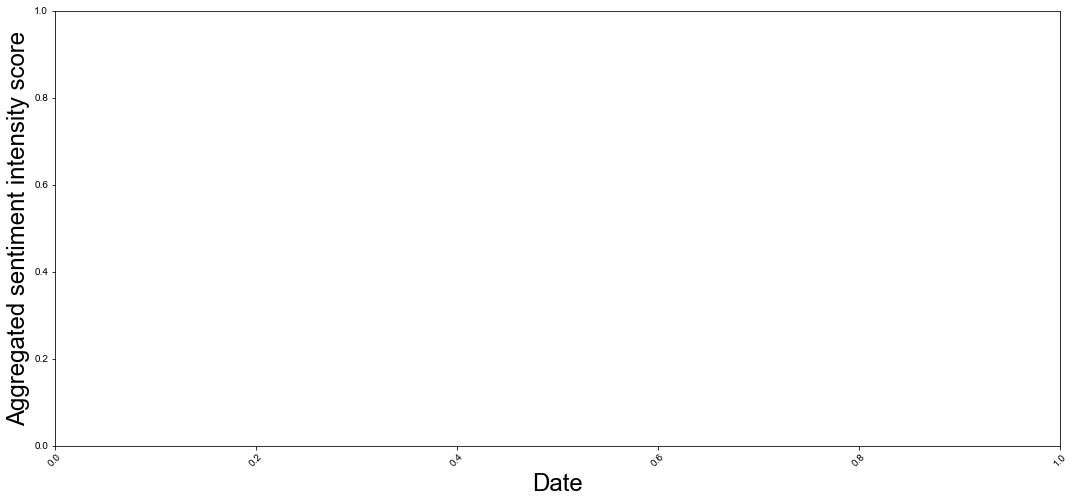

In [6]:
fig_1,ax_1 = plt.subplots(figsize=(18,8))
result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=1.8, font="PT Sans")


ax.plot(result_mon, result_values, '-o', color='#800020')
#plt.title('1 month aggregation scores for tweets', fontsize=18)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Aggregated sentiment intensity score', fontsize=24)

#ax.plot(agg_month_dates, agg_month_sentiment)
plt.xticks(rotation=45);
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 12 != 0:
        label.set_visible(False)

## 1 month aggregated and weighted sentiment intensity scores (based on speaker)
**Name list - multiplicative weight:**
1. Tim Cook  - 2.0
2. Steve Jobs - 1.9
3. Eddy Cue - 1.8
4. Jony Ive - 1.7
5. Donald Trump - 1.6
6. Phill Schiller - 1.5
7. Jeff Williams - 1.4
8. Steve Wozniak - 1.3
9. Ben Wood  -  1.2
10. Brian White  - 1.1

Based on our "Most frequently quoted speakers about Apple" bar chart race, we will give quotes that has a speaker to any of the people from the top 10 list some additional weight. 

In [7]:
speaker_weights = {
    "Tim Cook": 2,
    "Steve Jobs": 1.9,
     "Eddy Cue" : 1.8,
     "Jony Ive" : 1.7,
     "Donald Trump" : 1.6,
     "Phill Schiller" : 1.5,
     "Jeff Williams" : 1.4,
     "Steve Wozniak" : 1.3,
     "Ben Wood" : 1.2,
     "Brian White" : 1.1,
}

In this code block we do the same as we did in the one above, the only difference is that we scale the datapoint if it is included in the speaker weights dictionary.

In [8]:
agg_month_speaker_weight_sentiment = []
agg_month_speaker_weight_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    speaker = row['speaker']
    if index == 0:
        current_speaker_weight_month = date[:7]
        current_speaker_weight_size = 0


    tmp_speaker_weight_month = current_speaker_weight_month
    current_speaker_weight_month = date[:7] # the seven first digits of the date
    if tmp_speaker_weight_month != current_speaker_weight_month:
        agg_month_speaker_weight_sentiment.append(current_speaker_weight_size)
        current_speaker_weight_size = 0
        agg_month_speaker_weight_dates.append(current_speaker_weight_month)
    
    speaker_mult = 1
    if speaker in speaker_weights:
        speaker_mult = speaker_weights[speaker]
        
    # updates weighted aggregated value of positive and negative
    current_speaker_weight_size += row['compound']*row['numOccurrences']*speaker_mult

    
    

Here we have the 1 month aggregations scores which are multiplied by the speaker weights, which gives extra weight to the important speakers.

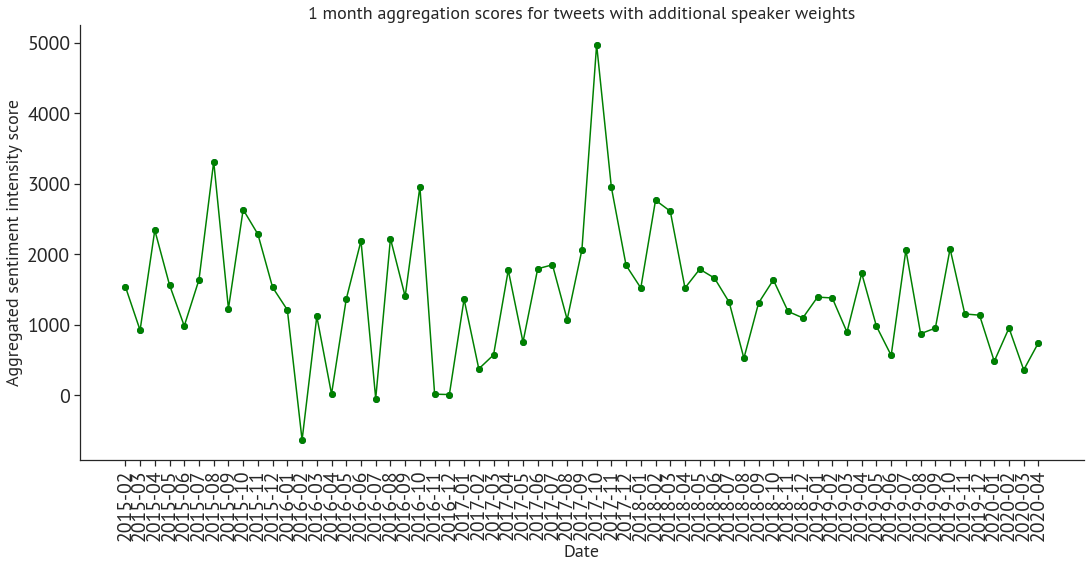

In [9]:
fig_2,ax_2 = plt.subplots(figsize=(18,8))
result_values = []
result_mon = []
for mon, agg in zip(agg_month_speaker_weight_dates, agg_month_speaker_weight_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

        

ax_2.scatter(result_mon, result_values)

ax_2.plot(result_mon, result_values, '-o', color='green')
plt.title('1 month aggregation scores for tweets with additional speaker weights', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Aggregated sentiment intensity score', fontsize=18)

#ax.plot(agg_month_dates, agg_month_sentiment)
plt.xticks(rotation=90);

<br><br>
## 1 week aggregated sentiment intensity scores
In this graph we will aggregate on each week, i.e. every 7 day we will make a data point on the graph. It is calculated counting one for each time the days change, when i reaches seven we "submit" the aggregated scores to the agg_week_sentiment list, which we will use for plotting. This way we get the aggregated scores for a 7 day period i.e. a week.

In [10]:
agg_week_sentiment_weekly = []
agg_week_dates_weekly = []
day_counter_weekly = 0
for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_day_weekly = date[:10]
        current_size_weekly = 0


    tmp_day_weekly = current_day_weekly
    current_day_weekly = date[:10] # the seven first digits of the date
    if tmp_day_weekly != current_day_weekly:
        day_counter_weekly += 1
    if day_counter_weekly == 7:
        agg_week_sentiment_weekly.append(current_size_weekly)
        agg_week_dates_weekly.append(current_day_weekly)
        current_size_weekly = 0
        day_counter_weekly = 0

    # updates weighted aggregated value of positive and negative
    current_size_weekly += row['compound']*row['numOccurrences']

    

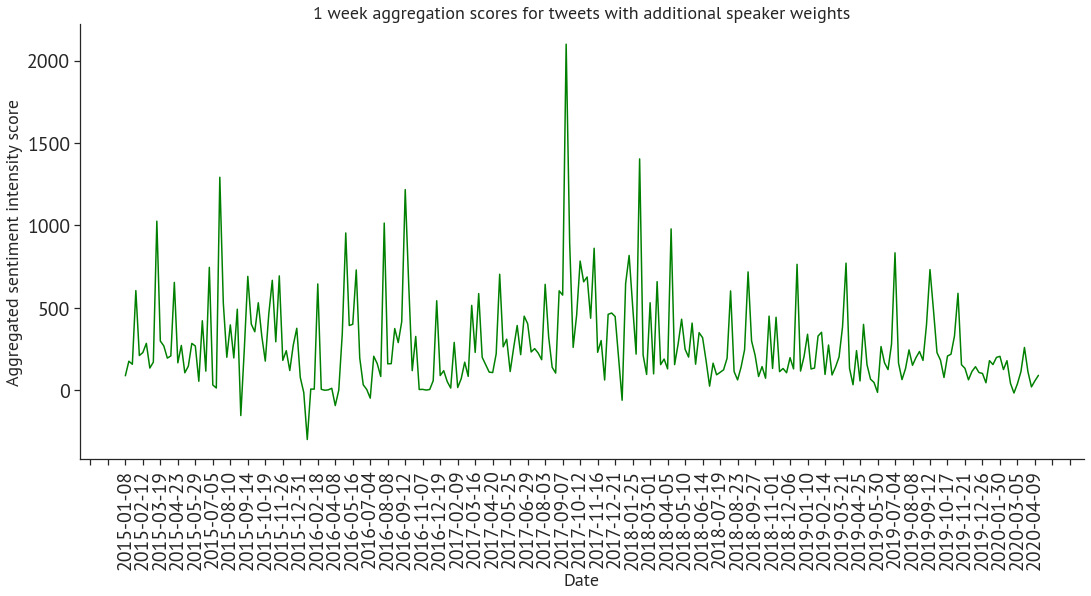

In [11]:
fig_3,ax_3 = plt.subplots(figsize=(18,8))
result_week_values = []
result_week = []
for week, agg in zip(agg_week_dates_weekly, agg_week_sentiment_weekly):
    result_week_values.append(agg)
    result_week.append(week)

        


ax_3.plot(result_week, result_week_values, color='green')
loc_weekly = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax_3.xaxis.set_major_locator(loc_weekly)
plt.title('1 week aggregation scores for tweets with additional speaker weights', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Aggregated sentiment intensity score', fontsize=18)

#ax.plot(agg_month_dates, agg_month_sentiment)
plt.xticks(rotation=90);

<br><br>
## 1 day aggregated sentiment intensity scores
In this graph we will aggregated quotes from each day, i.e. every unique day we will make a data point on the graph. It is calculated by "submitting" the scores every time the day changes in dateframe. This way we get the aggregated scores for each unique day.

In [12]:
agg_sentiment_daily = []
agg_dates_daily = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_day_daily = date[:10]
        current_size_daily = 0


    tmp_day_daily = current_day_daily
    current_day_daily = date[:10] # the seven first digits of the date
    if tmp_day_daily != current_day_daily:
        agg_sentiment_daily.append(current_size_daily)
        current_size_daily = 0
        agg_dates_daily.append(current_day_daily)

    # updates weighted aggregated value of positive and negative
    current_size_daily += row['compound']*row['numOccurrences']

    

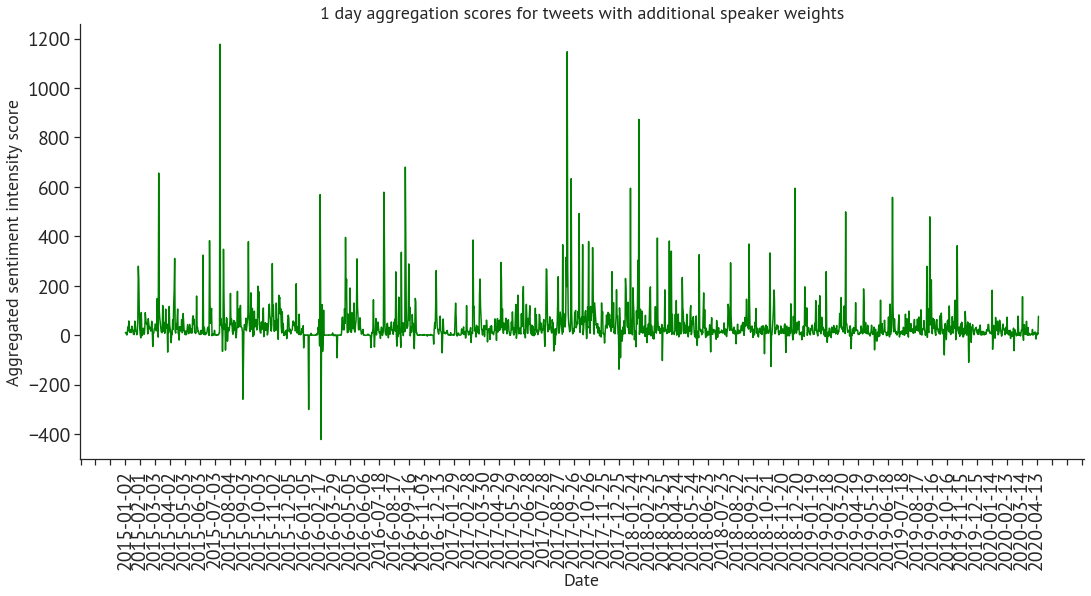

In [13]:
fig_4,ax_4 = plt.subplots(figsize=(18,8))
result_daily_values = []
result_daily = []
for day, agg in zip(agg_dates_daily, agg_sentiment_daily):
    result_daily_values.append(agg)
    result_daily.append(day)

        



ax_4.plot(result_daily, result_daily_values, color='green')
loc_daily = plticker.MultipleLocator(base=30) # this locator puts ticks at regular intervals
ax_4.xaxis.set_major_locator(loc_daily)
plt.title('1 day aggregation scores for tweets with additional speaker weights', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Aggregated sentiment intensity score', fontsize=18)

#ax.plot(agg_month_dates, agg_month_sentiment)
plt.xticks(rotation=90);